--- ROZPOCZYNAM POBIERANIE DANYCH ---
1. Pobieram granice dla: Warszawa, Poland...
2. Pobieram istniejące stacje ładowania...
3. Pobieram punkty POI (centra handlowe, biura)...

--- SUKCES! POBRANO DANE ---
Liczba stacji ładowania: 180
Liczba punktów POI: 12943


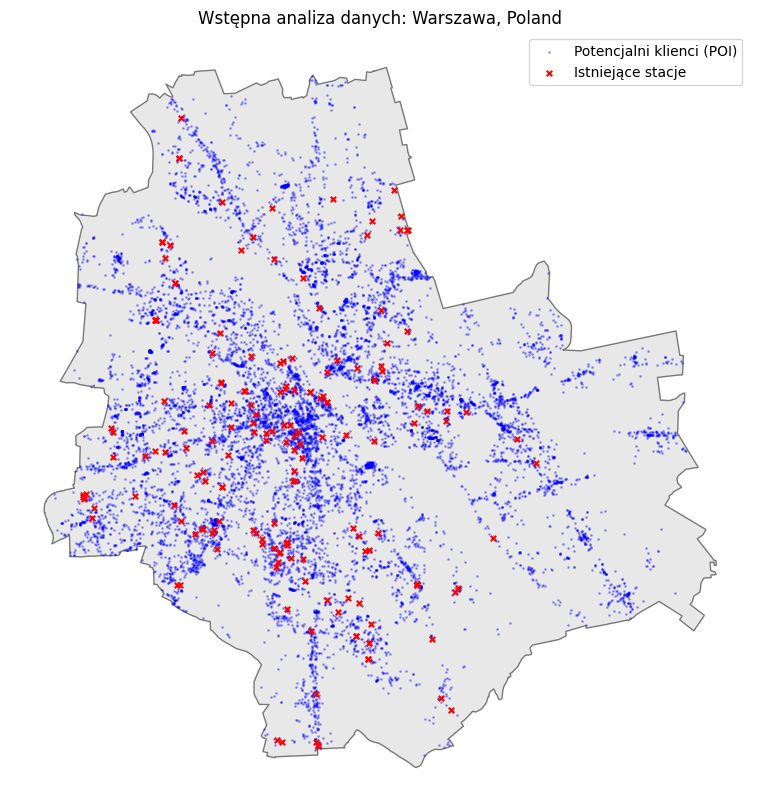

In [5]:
# KROK 0: Instalacja bibliotek (jeśli ich nie masz, odkomentuj poniższą linię)
#%pip install osmnx geopandas matplotlib folium h3 srai

#KROK 1
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt

# Konfiguracja
PLACE_NAME = "Warszawa, Poland"
CRS_PROJ = "EPSG:2180"

print("--- ROZPOCZYNAM POBIERANIE DANYCH ---")

print(f"1. Pobieram granice dla: {PLACE_NAME}...")
city_boundary = ox.geocode_to_gdf(PLACE_NAME)
city_boundary = city_boundary.to_crs(CRS_PROJ)

print("2. Pobieram istniejące stacje ładowania...")
tags_charging = {'amenity': 'charging_station'}
charging_stations = ox.features_from_place(PLACE_NAME, tags=tags_charging)

charging_stations = charging_stations[charging_stations.geom_type == 'Point']
charging_stations = charging_stations.to_crs(CRS_PROJ)

print("3. Pobieram punkty POI (centra handlowe, biura)...")
tags_poi = {
    'shop': ['mall', 'supermarket', 'department_store'],
    'amenity': ['cinema', 'theatre', 'university', 'restaurant'],
    'building': ['office', 'commercial', 'retail']
}
pois = ox.features_from_place(PLACE_NAME, tags=tags_poi)

pois = pois.to_crs(CRS_PROJ)
pois['geometry'] = pois.geometry.centroid
pois = pois[pois.geom_type == 'Point']

print(f"\n--- SUKCES! POBRANO DANE ---")
print(f"Liczba stacji ładowania: {len(charging_stations)}")
print(f"Liczba punktów POI: {len(pois)}")

# 4. Szybka wizualizacja sprawdzająca
fig, ax = plt.subplots(figsize=(10, 10))
city_boundary.plot(ax=ax, color='lightgrey', alpha=0.5, edgecolor='black')
pois.plot(ax=ax, color='blue', markersize=1, alpha=0.3, label='Potencjalni klienci (POI)')
charging_stations.plot(ax=ax, color='red', markersize=15, marker='x', label='Istniejące stacje')
plt.legend()
plt.title(f"Wstępna analiza danych: {PLACE_NAME}")
plt.axis('off')
plt.show()

--- ROZPOCZYNAM KROK 2 (METODA SRAI) ---
Generuję siatkę H3 (rezolucja 9)...
SUKCES! Utworzono 5575 heksagonów.
Zliczam punkty...

TOP 5 Lokalizacji:
                h3_id  poi_count  station_count  score_basic
861   891f53c984bffff      105.0            0.0        105.0
2978  891f53ca677ffff       83.0            0.0         83.0
3192  891f53c8277ffff       50.0            0.0         50.0
2060  891f53c852fffff       46.0            0.0         46.0
4592  891f52265d3ffff       45.0            0.0         45.0


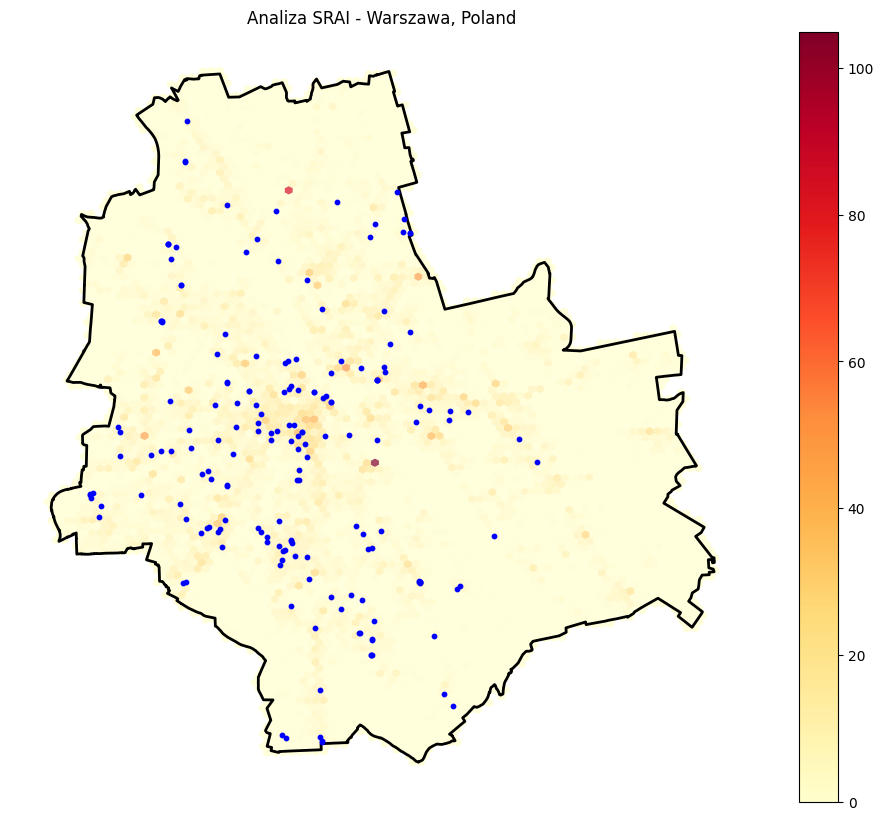

In [6]:
# KROK 2
# Upewnij się, że biblioteka jest zainstalowana (odkomentuj w razie potrzeby)
# %pip install srai

from srai.regionalizers import H3Regionalizer
import geopandas as gpd
import matplotlib.pyplot as plt

print("--- ROZPOCZYNAM KROK 2 (METODA SRAI) ---")

RESOLUTION = 9

# 1. Generowanie siatki za pomocą SRAI
# To jest ta magia - SRAI robi to w 2 linijkach i nie popełnia błędów geometrii
print(f"Generuję siatkę H3 (rezolucja {RESOLUTION})...")

try:
    regionalizer = H3Regionalizer(resolution=RESOLUTION)

    # SRAI wymaga EPSG:4326 na wejściu (współrzędne geograficzne)
    city_boundary_4326 = city_boundary.to_crs("EPSG:4326")

    # Transformacja - zwraca GeoDataFrame z indeksem h3_id
    grid = regionalizer.transform(city_boundary_4326)

    # Wyciągamy h3_id z indeksu do zwykłej kolumny (dla łatwiejszego łączenia)
    grid = grid.reset_index()

    # Zmieniamy nazwę kolumny indeksu na 'h3_id' jeśli nazywa się 'region_id' (standard SRAI)
    if 'region_id' in grid.columns:
        grid = grid.rename(columns={'region_id': 'h3_id'})

except Exception as e:
    print(f"Błąd SRAI: {e}")
    # W razie czego tworzymy pusty grid, żeby kod się nie wywalił całkowicie
    grid = gpd.GeoDataFrame()

if grid.empty:
    print("BŁĄD: Siatka jest pusta!")
else:
    # 2. Powrót do metrów (EPSG:2180) dla obliczeń i łączenia z punktami
    grid = grid.to_crs(CRS_PROJ)
    print(f"SUKCES! Utworzono {len(grid)} heksagonów.")

    # 3. Agregacja danych (Spatial Join)
    print("Zliczam punkty...")

    # Upewniamy się, że punkty też są w metrach (powinny być po Kroku 1)
    pois = pois.to_crs(CRS_PROJ)
    charging_stations = charging_stations.to_crs(CRS_PROJ)

    # A. Zliczanie POI
    join_poi = gpd.sjoin(grid, pois, how='inner', predicate='intersects')
    poi_counts = join_poi.groupby('h3_id').size().reset_index(name='poi_count')
    grid = grid.merge(poi_counts, on='h3_id', how='left').fillna({'poi_count': 0})

    # B. Zliczanie Stacji
    join_stat = gpd.sjoin(grid, charging_stations, how='inner', predicate='intersects')
    stat_counts = join_stat.groupby('h3_id').size().reset_index(name='station_count')
    grid = grid.merge(stat_counts, on='h3_id', how='left').fillna({'station_count': 0})

    # 4. Scoring (Ocena)
    grid['score_basic'] = grid['poi_count'] - (grid['station_count'] * 10)

    # Wyświetlenie wyników
    print("\nTOP 5 Lokalizacji:")
    print(grid[['h3_id', 'poi_count', 'station_count', 'score_basic']].sort_values('poi_count', ascending=False).head(5))

    # 5. Mapa kontrolna
    fig, ax = plt.subplots(figsize=(12, 10))
    grid.plot(ax=ax, column='poi_count', cmap='YlOrRd', alpha=0.7, legend=True)
    city_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=2)
    charging_stations.plot(ax=ax, color='blue', markersize=10, label='Stacje')
    plt.title(f"Analiza SRAI - {PLACE_NAME}")
    plt.axis('off')
    plt.show()

In [7]:
# --- KROK 3 i 4: SELEKCJA I WIZUALIZACJA KOŃCOWA ---
import folium
from shapely.geometry import Point

print("--- ROZPOCZYNAM FINAŁ: SELEKCJA I MAPA ---")

# 1. Algorytm inteligentnej selekcji (z buforem odległości)
# Sortujemy od najlepszego wyniku
candidates = grid.sort_values('score_basic', ascending=False).copy()

final_sites = []
MIN_DISTANCE = 1500  # Minimalna odległość między naszymi nowymi stacjami (w metrach)

print(f"Szukam 5 lokalizacji oddalonych od siebie o min. {MIN_DISTANCE}m...")

for index, row in candidates.iterrows():
    if len(final_sites) >= 5:
        break  # Mamy komplet

    current_point = row.geometry.centroid

    # Sprawdzamy czy nie jest za blisko już wybranych
    is_far_enough = True
    for site in final_sites:
        existing_point = site.geometry.centroid
        if current_point.distance(existing_point) < MIN_DISTANCE:
            is_far_enough = False
            break

    if is_far_enough:
        final_sites.append(row)

# Zamiana listy wybranych na GeoDataFrame
final_gdf = gpd.GeoDataFrame(final_sites, crs=grid.crs)
print(f"Wybrano {len(final_gdf)} lokalizacji.")

# 2. Przygotowanie mapy Folium
# Folium wymaga Lat/Lon (EPSG:4326)
grid_map = grid.to_crs("EPSG:4326")
final_map = final_gdf.to_crs("EPSG:4326")
stations_map = charging_stations.to_crs("EPSG:4326")
city_map = city_boundary.to_crs("EPSG:4326")

# Środek mapy
center_lat = city_map.geometry.centroid.y.mean()
center_lon = city_map.geometry.centroid.x.mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=12, tiles="cartodbpositron")

# WARSTWA A: Siatka Potencjału (Choropleth)
folium.Choropleth(
    geo_data=grid_map,
    data=grid_map,
    columns=['h3_id', 'score_basic'],
    key_on='feature.properties.h3_id',
    fill_color='YlOrRd',
    fill_opacity=0.4,
    line_opacity=0,
    legend_name='Indeks Potencjału (Score)',
    name='Analiza Potencjału'
).add_to(m)

# WARSTWA B: Istniejące stacje (Szare kropki)
for _, row in stations_map.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=3,
        color='gray',
        fill=True,
        fill_color='gray',
        popup="Istniejąca stacja (Konkurencja)"
    ).add_to(m)

# WARSTWA C: NASZE REKOMENDACJE (Zielone Markery)
for i, row in final_map.iterrows():
    lat = row.geometry.centroid.y
    lon = row.geometry.centroid.x
    score = row['score_basic']
    poi = row['poi_count']

    popup_html = f"""
    <div style="font-family: Arial; width: 200px;">
        <h4 style="color: green;">REKOMENDACJA #{i+1}</h4>
        <b>Wynik punktowy:</b> {score:.0f}<br>
        <b>Liczba POI w okolicy:</b> {poi:.0f}<br>
        <hr>
        <i>To miejsce ma duży popyt i brak konkurencji.</i>
    </div>
    """

    folium.Marker(
        location=[lat, lon],
        popup=folium.Popup(popup_html, max_width=250),
        icon=folium.Icon(color='green', icon='bolt', prefix='fa'),
        tooltip=f"Rekomendacja #{i+1}"
    ).add_to(m)

# Dodatki do mapy
folium.LayerControl().add_to(m)

# Wyświetlenie i zapis
m.save("mapa_projektowa.html")
print("Mapę zapisano do pliku 'mapa_projektowa.html'")
m

--- ROZPOCZYNAM FINAŁ: SELEKCJA I MAPA ---
Szukam 5 lokalizacji oddalonych od siebie o min. 1500m...
Wybrano 5 lokalizacji.


C:\Users\klimh\AppData\Local\Temp\ipykernel_55692\3547149999.py:45: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center_lat = city_map.geometry.centroid.y.mean()
C:\Users\klimh\AppData\Local\Temp\ipykernel_55692\3547149999.py:46: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center_lon = city_map.geometry.centroid.x.mean()


Mapę zapisano do pliku 'mapa_projektowa.html'
